<a href="https://colab.research.google.com/github/jhmendonca/stablediffusion/blob/main/Diffusers_Treinamento_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**O que é um agendador?**

As funções de agendamento, denominadas Schedulers na biblioteca, recebem a saída de um modelo treinado, uma amostra na qual o processo de difusão está iterando e um intervalo de tempo para retornar uma amostra sem ruído. É por isso que escalonadores também podem ser chamados de Samplers em outras implementações de modelos de difusão.

1. Os agendadores definem a metodologia para adicionar ruído iterativamente a uma imagem ou para atualizar uma amostra com base nas saídas do modelo.
    * adicionar ruído de diferentes maneiras representa os processos algorítmicos para treinar um modelo de difusão adicionando ruído às imagens.
    * para inferência, o planejador define como atualizar uma amostra com base em uma saída de um modelo pré-treinado.
2. Os escalonadores geralmente são definidos por um escalonamento de ruído e uma regra de atualização para resolver a solução da equação diferencial.

Eles podem ser bastante complexos e geralmente definem uma compensação entre velocidade de remoção de ruído e qualidade de remoção de ruído . É extremamente difícil medir quantitativamente qual agendador funciona melhor para um determinado pipeline de difusão, portanto, geralmente é recomendável simplesmente testar qual funciona melhor.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!mkdir /content/gdrive/MyDrive/stable-diffusion-v1-5
!git lfs install
!git clone --branch fp16 https://huggingface.co/runwayml/stable-diffusion-v1-5/  /content/gdrive/MyDrive/stable-diffusion-v1-5

mkdir: cannot create directory ‘/content/gdrive/MyDrive/stable-diffusion-v1-5’: File exists
Git LFS initialized.
fatal: destination path '/content/gdrive/MyDrive/stable-diffusion-v1-5' already exists and is not an empty directory.


In [3]:
!pip install -qq -U transformers diffusers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.2 MB/s eta 0:00:00


In [4]:
from diffusers import DiffusionPipeline
import torch

pipeline = DiffusionPipeline.from_pretrained("/content/gdrive/MyDrive/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipeline.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.19.3",
  "_name_or_path": "/content/gdrive/MyDrive/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

O agendador é sempre um dos componentes do pipeline e geralmente é chamado de "scheduler". Portanto, pode ser acessado através da "scheduler"propriedade.

In [5]:
pipeline.scheduler

PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.19.3",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "leading",
  "trained_betas": null
}

Podemos ver que o agendador é do tipo PNDMScheduler . Legal, agora vamos comparar o desempenho do escalonador com outros escalonadores. Primeiro, definimos um prompt no qual testaremos todos os diferentes agendadores:

In [6]:
prompt = "a man with glasses in the park taking a selfie"

Em seguida, criamos um gerador a partir de uma semente aleatória que garantirá que possamos gerar imagens semelhantes, bem como executar o pipeline:

  0%|          | 0/50 [00:00<?, ?it/s]

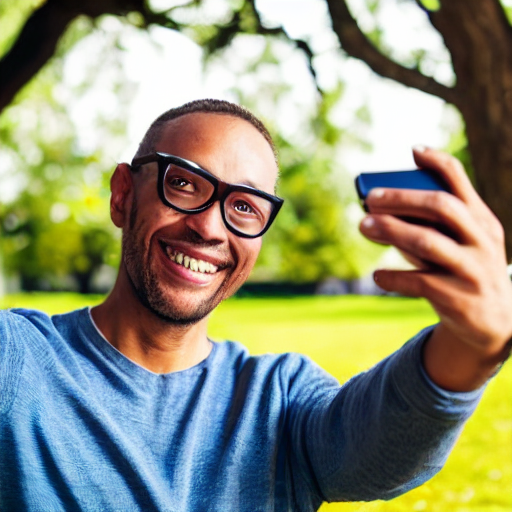

In [7]:
generator = torch.Generator(device="cuda").manual_seed(8)
image = pipeline(prompt, generator=generator).images[0]
image

Agora mostramos como é fácil alterar o escalonador de um pipeline. Cada escalonador tem uma propriedade SchedulerMixin.compatibles que define todos os escalonadores compatíveis. Você pode dar uma olhada em todos os agendadores compatíveis disponíveis para o pipeline Stable Diffusion da seguinte maneira.

In [8]:
pipeline.scheduler.compatibles

[diffusers.schedulers.scheduling_ddpm.DDPMScheduler,
 diffusers.schedulers.scheduling_euler_discrete.EulerDiscreteScheduler,
 diffusers.schedulers.scheduling_lms_discrete.LMSDiscreteScheduler,
 diffusers.schedulers.scheduling_euler_ancestral_discrete.EulerAncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler,
 diffusers.schedulers.scheduling_pndm.PNDMScheduler,
 diffusers.schedulers.scheduling_heun_discrete.HeunDiscreteScheduler,
 diffusers.schedulers.scheduling_dpmsolver_singlestep.DPMSolverSinglestepScheduler,
 diffusers.utils.dummy_torch_and_torchsde_objects.DPMSolverSDEScheduler,
 diffusers.schedulers.scheduling_deis_multistep.DEISMultistepScheduler,
 diffusers.schedulers.scheduling_ddim.DDIMScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_ancestral_discrete.KDPM2AncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_discrete.KDPM2DiscreteScheduler,
 diffusers.schedulers.scheduling_unipc_multistep.UniPCMultiste

Vamos agora comparar o prompt de entrada com todos os outros agendadores. Para alterar o agendador do pipeline, você pode usar a ConfigMixin.configpropriedade conveniente em combinação com a função ConfigMixin.from_config() .

In [11]:
pipeline.scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('clip_sample', False),
            ('set_alpha_to_one', False),
            ('steps_offset', 1),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('timestep_spacing', 'leading'),
            ('rescale_betas_zero_snr', False),
            ('_use_default_values',
             ['sample_max_value',
              'rescale_betas_zero_snr',
              'dynamic_thresholding_ratio',
              'timestep_spacing',
              'prediction_type',
              'thresholding',
              'clip_sample_range']),
            ('skip_prk_steps', True),
            ('_class_name', 'PNDMScheduler'),
            ('_di

retorna um dicionário da configuração do agendador:

Essa configuração pode ser usada para instanciar um agendador de uma classe diferente que seja compatível com o pipeline. Aqui, alteramos o agendador para DDIMScheduler .

In [16]:
from diffusers import KDPM2DiscreteScheduler

pipeline.scheduler = KDPM2DiscreteScheduler.from_config(pipeline.scheduler.config)

In [18]:
pipeline.scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('prediction_type', 'epsilon'),
            ('timestep_spacing', 'linspace'),
            ('steps_offset', 1),
            ('_use_default_values', ['timestep_spacing', 'prediction_type']),
            ('clip_sample', False),
            ('set_alpha_to_one', False),
            ('skip_prk_steps', True),
            ('_class_name', 'PNDMScheduler'),
            ('_diffusers_version', '0.19.3')])

agora podemos executar o pipeline novamente para comparar a qualidade da geração.

  0%|          | 0/50 [00:00<?, ?it/s]

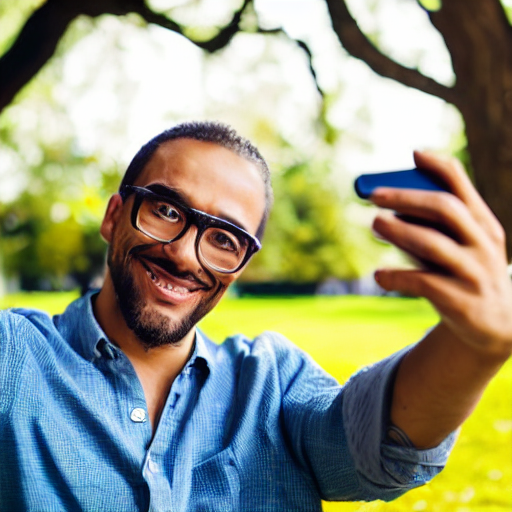

In [17]:
generator = torch.Generator(device="cuda").manual_seed(8)
image = pipeline(prompt, generator=generator).images[0]
image